# Acknowledgement

Parts of this pset were inspired by
* Berkeley CS294-158, taught by Pieter Abbeel, Wilson Yan, Kevin Frans, and Philipp Wu;
* MIT 6.S184/6.S975, taught by Peter Holderrieth and Ezra Erives;
* The [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) about diffusion models by Lilian Weng.

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file. 

Specifically, for Problem 2 in this notebook, the pdf should contain:
- The generated figures `results/p2_train_plot.png` and `results/p2_toy_samples.png`

# Problem 2: Training Diffusion Models on a Toy Dataset
In this problem, we will write the code for training and sampling from a diffusion model on a 2D toy dataset. This part requires GPUs--you can use Google Colab for GPU access. To work on this notebook in Google Colab, copy the `pset-5` directory to your Google Drive and open this notebook. Then, start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## Data Generation and Visualization

In [123]:
from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os
from os.path import exists, dirname

In [124]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [125]:
def toy_2d_data(n=100000):
    x, _ = make_s_curve(n, noise=0.1)
    x = x[:, [0, 2]]
    return x.astype('float32')

In [126]:
def visualize_toy_2d_dataset():
    data = toy_2d_data()
    plt.figure()
    plt.scatter(data[:, 0], data[:, 1])
    plt.show()

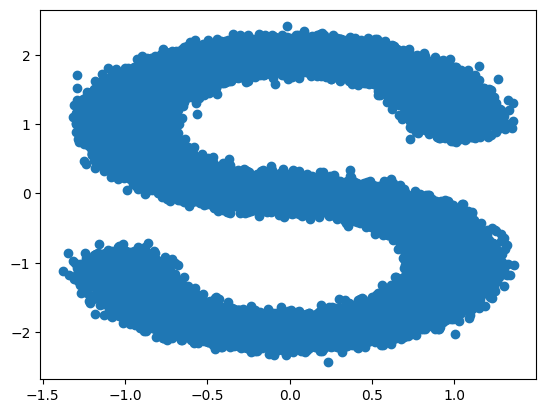

In [127]:
visualize_toy_2d_dataset()

## Training and Sampling of Diffusion Models

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:

0. Construct a class `Diffusion`
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and cmpute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))
* Training 100 epochs takes about 2 minutes on the Google Colab T4 GPU.


To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
*Note*: As a sanity check, when $\eta_t$ follows the DDPM setting as shown above, the resulted coefficient of $x_t$ and $\hat{\epsilon}$ should be the same as $A'$ and $B'$ you derived in Problem 1.2 (6) where $\alpha_t$ here corresponds to $\bar{\alpha_t}$ in Problem 1.

To run the reverse process, start from $x_1 \sim N(0, I)$. Then perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
*Note*:
* If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0
* For debugging, you can start with trying small number of epochs. To debug your training code, you can check whether the training and testing losses decrease properly. To debug your sampling code, you can check whether the generated distribution is close to the S-shape target distribution with large `num_steps`.
* To check your answer, the final text loss is roughly around 0.4.

--- Diffusion Model Components ---

In [128]:
class Diffusion:
    def __init__(self, model, data_shape):
        """
        model: neural network to estimate eps_hat (MLP in this problem)
        data_shape: size of the input data, (2,) in this case
        """
        self.model = model.to(DEVICE)
        self.data_shape = data_shape

    def loss(self, x):
        """
        x: the input data (without adding noise) from the dataloader
        Return:
            The loss (as a scalar averaged over all data in the batch)
        """
        t = torch.rand(x.shape[0], device=DEVICE)

        alpha_t, sigma_t = torch.cos((math.pi / 2) ** t), torch.sin((math.pi / 2) ** t)
        epsilon = torch.randn_like(x, device=DEVICE)
        x_t = alpha_t.unsqueeze(-1) * x + sigma_t.unsqueeze(-1) * epsilon

        eps_hat = self.model(x_t, t)

        loss = torch.mean((epsilon - eps_hat)**2)
        return loss

    @torch.no_grad()
    def sample(self, n, num_steps):
        """
        n: number of samples to generate
        num_steps: number of steps in the diffusion sampling
        Return:
            The generated sample. Tensor with shape (n, *self.data_shape)
        """
        ts = torch.linspace(1.0 - 1e-4, 1e-4, num_steps + 1, device=DEVICE)
        x = torch.randn(n, *self.data_shape, device=DEVICE)

        for i in range(num_steps):
            t_current = ts[i]
            alpha_t, sigma_t = torch.cos((math.pi / 2) * t_current), torch.sin((math.pi / 2) * t_current)

            t_next = ts[i + 1]
            alpha_next, sigma_next = torch.cos((math.pi / 2) * t_next), torch.sin((math.pi / 2) * t_next)

            t_expanded = t_current.expand(n)
            eps_pred = self.model(x, t_expanded)
            
            sigma_t = torch.clamp(sigma_t, min=1e-12)
            sigma_next = torch.clamp(sigma_next, min=1e-12)
            
            noise_coef = (sigma_next / sigma_t) * torch.sqrt(torch.clamp(1 - (alpha_t**2) / (alpha_next**2), min=0.0))
            
            x = (alpha_next * ((x - sigma_t * eps_pred) / alpha_t)) + \
                torch.sqrt(torch.clamp(sigma_next**2 - noise_coef**2, min=0.0)) * eps_pred + \
                noise_coef * torch.randn_like(x)
            
        return x

    def __getattr__(self, name):
        if name in ['train', 'eval', 'parameters', 'state_dict', 'load_state_dict']:
            return getattr(self.model, name)
        return self.__getattribute__(name)

In [129]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden_layers, timestep_dim=1):
        super().__init__()
        self.timestep_dim = timestep_dim
        prev_dim = input_dim + timestep_dim
        net = []
        dims = [hidden_dim] * n_hidden_layers + [input_dim]
        for i, dim in enumerate(dims):
            net.append(nn.Linear(prev_dim, dim))
            if i < len(dims) - 1:
                net.append(nn.ReLU())
            prev_dim = dim
        self.net = nn.Sequential(*net)

    def forward(self, x, t):
        x = torch.cat([x, t[:, None]], dim=1)
        return self.net(x)

In [130]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

def train(model, train_loader, optimizer, scheduler):
    """
    model: model to train, the Diffusion class in this case.
    train_loader: dataloader for the train_data after normalization
    optimizer: use torch.optim.Adam
    scheduler: use optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
    )
    Return:
        Tensor with train loss of each batch
    """
    result = []
    model.train()
    device = next(model.parameters()).device

    for (x,) in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        loss = model.loss(x)
        loss.backward()
        optimizer.step()
        scheduler.step()
        result.append(loss.item())

    return np.array(result)


@torch.no_grad()
def eval_loss(model, data_loader):
    """
    model: model to train, the Diffusion class in this case.
    data_loader: dataloader for the test_data after normalization
    Return:
        Scalar with the average test loss of each batch
    """
    result = 0.0
    tot = 0
    model.eval()
    device = next(model.parameters()).device

    for (x,) in data_loader:
        x = x.to(device)
        loss = model.loss(x)
        result += loss.item()
        tot += 1
    return result / tot

def get_lr(step, total_steps, warmup_steps, use_cos_decay):
    """
    Function that returns the learning rate for the specific step, used in defining the scheduler:
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer,
            lr_lambda=lambda step: get_lr(step, total_steps, warmup_steps, use_cos_decay)
        )
    """
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        if use_cos_decay:
            return 0.5 * (1.0 + math.cos(math.pi * ((step - warmup_steps) / float(max(1, total_steps - warmup_steps)))))
        else:
            return 1.0

def train_epochs(model, train_loader, test_loader, train_args):
    """
    model: model to train, the Diffusion class in this case.
    train_loader: dataloader for the train_data after normalization
    test_loader: dataloader for the test_data after normalization
    Return:
        Two np.array for all the train losses and test losses at each step
    """
    epochs, lr = train_args['epochs'], train_args['lr']
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)

    tot = epochs * len(train_loader)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(
            step, tot, warmup_steps, use_cos_decay
        )
    )

    res = [eval_loss(model, test_loader)]
    tloss = []

    for _ in range(epochs):
        losses = train(model, train_loader, optimizer, scheduler)
        tloss.extend(losses)

        # Evaluate on test set
        test_l = eval_loss(model, test_loader)
        res.append(test_l)

    return np.array(tloss), np.array(res)


--- Main Function and Plotting ---

In [131]:
import torch.utils.data as data

def toy_diffusion(train_data, test_data):
    """
    train_data: A (100000, 2) numpy array of 2D points
    test_data: A (10000, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (9, 2000, 2) of samples drawn from your model.
      Draw 2000 samples for each of 9 different number of diffusion sampling steps
      of evenly logarithmically spaced integers 1 to 512
      hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    mu = train_data.mean(axis=0, keepdims=True)
    std = train_data.std(axis=0, keepdims=True)

    train_dataset = data.TensorDataset(torch.tensor(((train_data - mu) / std)))
    test_dataset = data.TensorDataset(torch.tensor(((test_data - mu) / std)))
    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

    mlp = MLP(input_dim=2, hidden_dim=64, n_hidden_layers=4).to(device)
    diffmodel = Diffusion(mlp, data_shape=(2,))

    train_losses, test_losses = train_epochs(diffmodel, train_loader, test_loader, {'epochs': 100, 'lr': 1e-3, 'warmup': 100, 'use_cos_decay': True})

    result = []
    stesp = np.power(2, np.linspace(0, 9, 9)).astype(int)
    for steps in stesp:
        sam = diffmodel.sample(n=2000, num_steps=steps)
        sam = sam.cpu().numpy() * std + mu
        result.append(sam)

    result = np.stack(result, axis=0)

    return train_losses, test_losses, result

In [132]:
import os
from os.path import exists, dirname

def savefig(fname: str, show_figure: bool = True) -> None:
    if not exists(dirname(fname)):
        os.makedirs(dirname(fname))
    plt.tight_layout()
    plt.savefig(fname)
    if show_figure:
        plt.show()


def save_training_plot(
    train_losses: np.ndarray, test_losses: np.ndarray, title: str, fname: str
) -> None:
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label="train loss")
    plt.plot(x_test, test_losses, label="test loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("NLL")
    savefig(fname)

In [133]:
def save_multi_scatter_2d(data: np.ndarray) -> None:
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    num_steps = np.power(2, np.linspace(0, 9, 9)).astype(int)
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(data[i * 3 + j, :, 0], data[i * 3 + j, :, 1])
            axs[i, j].set_title(f'Steps = {num_steps[i * 3 + j]}')
    savefig("results/p2_toy_samples.png")


def toy_save_results(fn):
    train_data = toy_2d_data(n=100000)
    test_data = toy_2d_data(n=10000)
    train_losses, test_losses, samples = fn(train_data, test_data)

    print(f"Final Test Loss: {test_losses[-1]:.4f}")

    save_training_plot(
        train_losses,
        test_losses,
        f"P2 Train Plot",
        f"results/p2_train_plot.png"
    )

    save_multi_scatter_2d(samples)

Final Test Loss: 0.1135


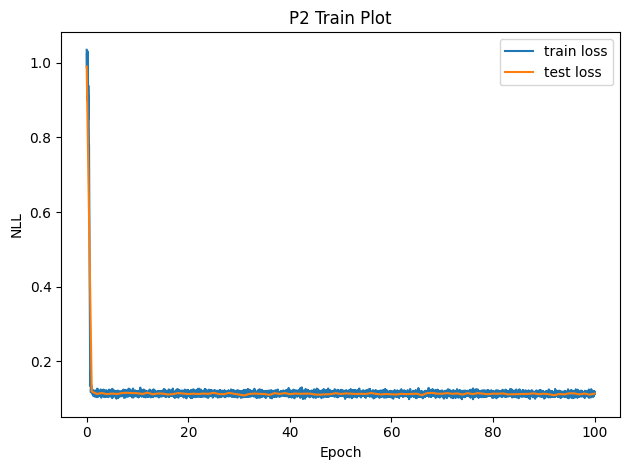

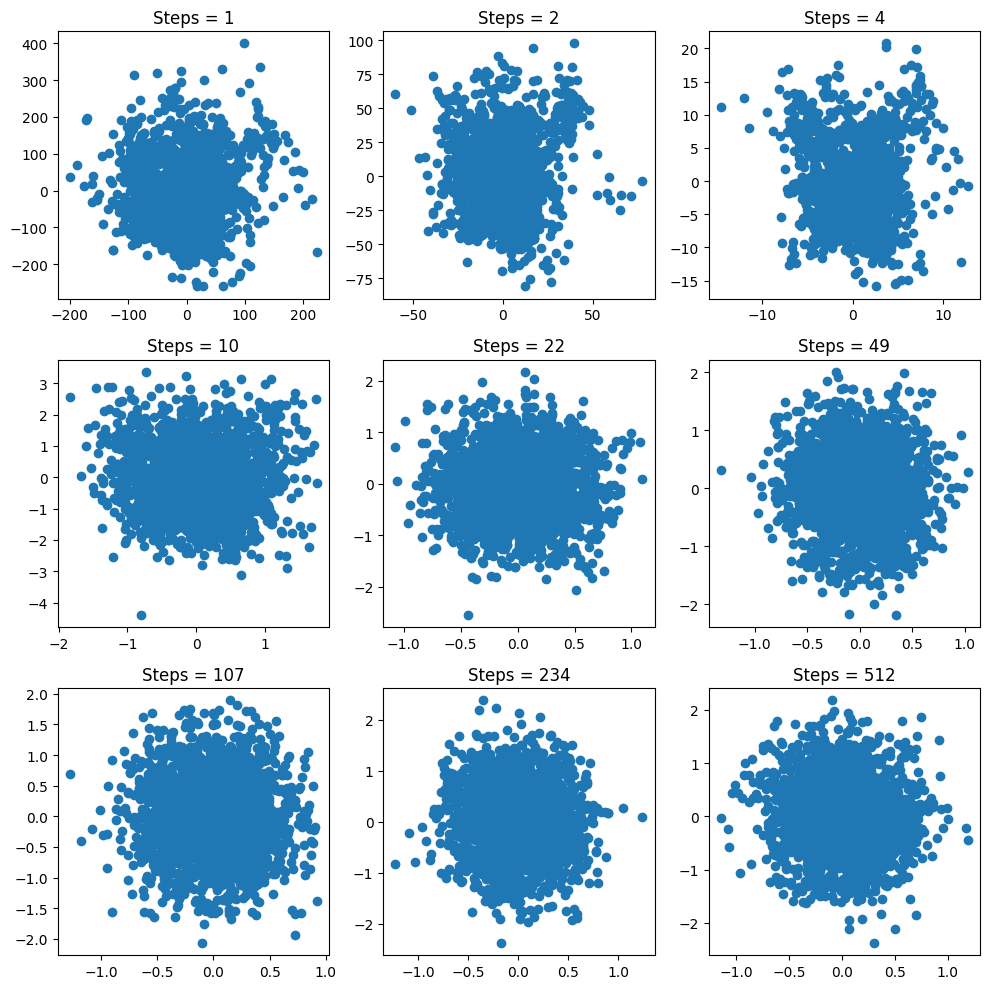

In [134]:
if __name__ == "__main__":
    toy_save_results(toy_diffusion)

# Submission Guideline for Part 2

Please include your answer to all problems, including formulas, proofs, and the figures generated in each problem, excluding code. You are required to submit the (single) pdf and all (four) notebooks (one for each problem) with your code and running outputs. Do not include code in the pdf file.

Specifically, for Problem 2 in this notebook, the pdf should contain:
- The generated figures `results/p2_train_plot.png` and `results/p2_toy_samples.png`